In [1]:
#generic definitions: to get the plotting style correct it seems like this needs to be evaluated twice...

import ROOT
import os
import time
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats.distributions import chi2
from stat_helpers import *
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use([hep.style.CMS, hep.style.firamath])
import itertools

import datetime
_plotsdir='/eos/user/p/psilva/www/sdanalysis/{}'.format(datetime.datetime.now().strftime('%Y%b%d'))
os.system('mkdir -p {}'.format(_plotsdir))

_file_list={}
_datadir='/eos/user/p/psilva/data/sdanalysis'
for ds in ['SingleMuon']: #,'HighEGJet','HighEGJet_emu']:
    url=f'{_datadir}/{ds}/Chunks'
    _file_list[ds]=[os.path.join(url,f) for f in os.listdir(url) if '.root' in f]
    print(f'{ds} has {len(_file_list[ds])} files')

print(f'Summaries will be stored in {_datadir}')

Welcome to JupyROOT 6.24/06
SingleMuon has 48 files
Summaries will be stored in /eos/user/p/psilva/data/sdanalysis


# W/Z/$e\mu$ selections

We apply the final selection for W&rightarrow;&mu;&nu;, Z&rightarrow;&mu;&mu; or e&mu; events.

NB: This only needs to be done once in a while if you change something, otherwise the output will be stored in hdf format and can be read when starting back the notebook.

In [48]:
def selectSDBoson(url):
    
    """
    select single diffractive W candidates
    """
    
    ROOT.ROOT.EnableImplicitMT()
     
    #define the selections and branches with an RDataFrame
    rdf=ROOT.RDataFrame("Events", url)
    
    #Z stream
    lepcuts='nano_nLeptons==2 && nano_LepPT>20 && ((nano_LepID==13 && abs(nano_LepEta)<2.1) || nano_LepID==11 || nano_LepID==143) && nano_mll>50.'
    jetcuts='nano_nJets<=1'
    zrdf = rdf.Filter(lepcuts,'=2 leptons') \
              .Filter(jetcuts,'<=1 jet') \
              .Define('probe_isiso', 'int(nano_LepIsIso)') \
              .Define('probe_eta',   'nano_Etall') \
              .Define('probe_phi',   'nano_Phill') \
              .Define('probe_pt',    'nano_Ptll') \
              .Define('boson_m',     'nano_mll') \
              .Define('boson_pt',    'nano_Ptll') \
              .Define('boson_phi',   'nano_Phill') \
              .Define('channel',    'nano_LepID==143 ? 143 : (nano_LepID==11 ? 121 : 169)')
    
    #W stream
    lepcuts  = 'nano_nLeptons==1 '
    lepcuts += '&& abs(nano_LepDxy) < 0.5 && abs(nano_LepDz)<1.0'
    jetcuts='nano_nJets<=1'
    wrdf = rdf.Filter(lepcuts,       '=1 lepton') \
              .Filter(jetcuts,       '<=1 jet') \
              .Define('probe_isiso', 'int(nano_LepIsIso)') \
              .Define('probe_eta',   'nano_LepEta') \
              .Define('probe_pt',    'nano_LepPT') \
              .Define('probe_phi',   'nano_LepPhi') \
              .Define('boson_m',     'nano_WMT') \
              .Define('boson_pt',    'nano_WPT') \
              .Define('boson_phi',   'nano_WPhi') \
              .Define('channel',    'nano_LepID==11 ?  11 : 13')
    
    #join dataframes and re-inforce some datatypes
    columns={#'PV_npvs':'npv', 
             'PV_npvsGood':'npvgood', 
             'nIsoTrack':'ntrk',
             'nano_LepDxy':'dxy',
             'nano_LepDz':'dz',
             'probe_isiso':'isiso', 
             'probe_eta':'probe_eta', 
             'probe_phi':'probe_phi',
             'probe_pt':'probe_pt',
             'boson_m':'boson_m',
             'boson_pt':'boson_pt',  
             'boson_phi':'boson_phi',
             'channel':'channel',
             'nano_JetPT':'jet_pt', 
             'nano_JetEta':'jet_eta', 
             'nano_JetPhi':'jet_phi',
             'MET_pt':'met_pt',     
             'MET_phi':'met_phi',
             'nano_nProtons':'nprotons',
             'nano_xip':'xip',
             'nano_xin':'xin',
             'nano_pzpfjp':'pzpfjp',
             'nano_pzpfjm':'pzpfjn'}
    orig_columns=[x for x,_ in columns.items()]
    data = pd.concat( [ 
        pd.DataFrame( zrdf.AsNumpy(columns=orig_columns), columns=orig_columns),
        pd.DataFrame( wrdf.AsNumpy(columns=orig_columns), columns=orig_columns)
        ],
        ignore_index=True)
    data.rename(columns=columns,inplace=True)
    data=data.astype(dict([(x,'int32') for x in ['npvgood','ntrk','channel','nprotons','isiso']]))
    
    ROOT.ROOT.DisableImplicitMT()
        
    return data

for ds,files in _file_list.items():
    
    start = time.time()
    data=selectSDBoson(files)
    end = time.time()
    print(f'{ds} Selected {data.shape[0]} events for analysis')
    print('\tElapsed time {:3.3f} s'.format(end-start))

    nZcands  = ((data['channel']==121) | (data['channel']==169) ).sum()
    nWcands  = ((data['channel']==11)  | (data['channel']==13) ).sum()
    nEMcands = (data['channel']==143).sum()
    print(f'\tnZs={nZcands:d} nWs={nWcands:d} nEMs={nEMcands:d}')

    outurl=os.path.join(_datadir,f'{ds}Summary.h5')
    data.to_hdf(outurl,key='data')
    print(f'\t Output summary stored in {outurl}')

SingleMuon Selected 5872722 events for analysis
	Elapsed time 51.522 s
	nZs=144189 nWs=5728533 nEMs=0
	 Output summary stored in /eos/user/p/psilva/data/sdanalysis/SingleMuonSummary.h5


# Read selection summary

Start from here if you don't need to select again the boson samples.

The data is read and some generic masks and additional variables are defined.

In [49]:
data=[]
for ds in ['SingleMuon']: #,'HighEGJet','HighEGJet_emu']:
    url=os.path.join(_datadir,f'{ds}Summary.h5')
    data.append( pd.read_hdf(url,key='data') )
data=pd.concat(data, ignore_index=True)
data.head()

npvgood  ntrk       dxy        dz  isiso  probe_eta  probe_phi   probe_pt  \
0        3     0  0.000546  0.000802      1  -2.198301   0.920306   9.053396   
1        2     0 -0.000735 -0.002201      1   2.367410  -0.617524   8.737578   
2        4     0 -0.000563  0.001023      1   1.538036  -1.009634  31.216793   
3        3     0  0.003792  0.004875      0   2.005134   1.742884  26.103823   
4        3     0 -0.000294  0.000103      1   2.537000  -1.348127   4.436682   

      boson_m   boson_pt  ...   jet_pt     jet_eta     jet_phi     met_pt  \
0  103.464050   9.053396  ...  -1.0000 -999.000000 -999.000000  14.932534   
1   93.484474   8.737578  ...  -1.0000 -999.000000 -999.000000  14.590998   
2   79.110634  31.216793  ...  -1.0000 -999.000000 -999.000000  15.884093   
3   89.575302  26.103823  ...  53.9375    1.804688   -1.101318   9.059284   
4   54.784126   4.436682  ...  -1.0000 -999.000000 -999.000000  13.248794   

    met_phi  nprotons       xip       xin      pzpfjp  pzpfjn  
0 -1.603516         0 -1.000000 -1.000000    0.000000     0.0  
1  2.566406         0 -1.000000 -1.000000    0.000000     0.0  
2  2.532715         1  0.125031 -1.000000    0.000000     0.0  
3 -2.352051         0 -1.000000 -1.000000  159.480942     0.0  
4 -2.939453         1 -1.000000  0.134399    0.000000     0.0  

[5 rows x 22 columns]

In [50]:
mask=(data['channel']==13)  & (data['isiso']==0)  & (data['boson_m']>40.)
wdata=data[mask].copy()
wdata['xi']=np.where(wdata['xip']>0,wdata['xip'],wdata['xin'])
mask_p=((wdata['xip']>0.025) & (wdata['xip']<0.15)) | ((wdata['xin']>0.040) & (data[f'xin']<0.18))
wdata.head()

npvgood  ntrk       dxy        dz  isiso  probe_eta  probe_phi  \
144196        3     1  0.008583 -0.001688      0   0.848267  -0.054283   
144216        3     0  0.001131  0.002258      0   2.201172  -1.887207   
144222        2     0  0.000151  0.000827      0   1.667236  -0.389282   
144241        3     0 -0.005775  0.022522      0   1.593506   1.595215   
144256        1     1  0.014183 -0.131104      0   2.291504   2.900879   

         probe_pt    boson_m   boson_pt  ...   jet_eta   jet_phi     met_pt  \
144196  25.839569  46.656731  58.512798  ...  0.353271 -2.039062  48.997574   
144216  24.605425  55.569389   7.147906  ...  2.267090 -1.894531  31.421799   
144222  29.562263  57.870132  17.944609  ...  1.643311 -0.419006  31.026196   
144241  30.356041  44.055397  20.703514  ...  1.592773  1.603516  18.321608   
144256  28.819889  49.284100  21.778044  ...  2.266113  2.916016  25.061516   

         met_phi  nprotons  xip  xin      pzpfjp  pzpfjn   xi  
144196  1.375732         0 -1.0 -1.0   53.039410     0.0 -1.0  
144216  1.331787         0 -1.0 -1.0  287.985809     0.0 -1.0  
144222  2.152832         0 -1.0 -1.0  111.948021     0.0 -1.0  
144241 -2.276855         0 -1.0 -1.0  434.283905     0.0 -1.0  
144256 -1.061768         0 -1.0 -1.0  356.454254     0.0 -1.0  

[5 rows x 23 columns]

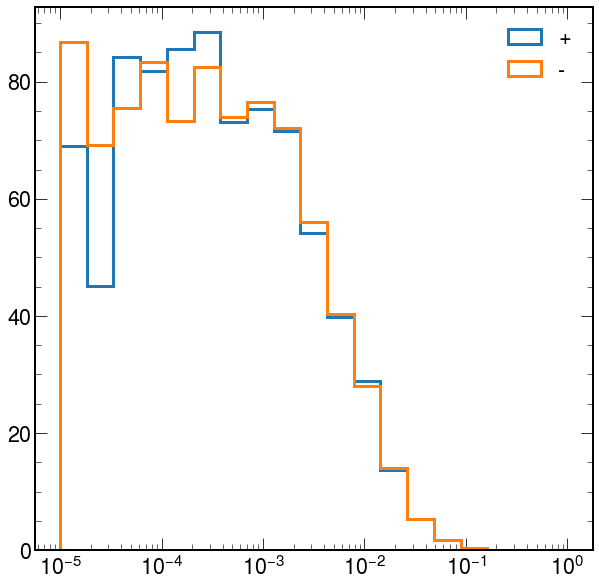

In [103]:
sqrts=13000.
mask_p=(wdata['xip']>0) & (wdata['xin']<0)
mask_n=(wdata['xin']>0) & (wdata['xip']<0)
mask_np= mask_p | mask_n

wdata['xipfp']=wdata['pzpfjp']/sqrts
wdata['xipfn']=-wdata['pzpfjn']/sqrts
wdata['xipf']=np.abs(wdata['pzpfjp']+wdata['pzpfjn'])/sqrts

bins=np.logspace(-5,0,20)
plt.hist(wdata[mask_p]['xipf'],histtype='step',bins=bins,density=True,label='+',lw=3)
plt.hist(wdata[mask_n]['xipf'],histtype='step',bins=bins,density=True,label='-',lw=3)
plt.xscale('log')
plt.legend()
plt.show()

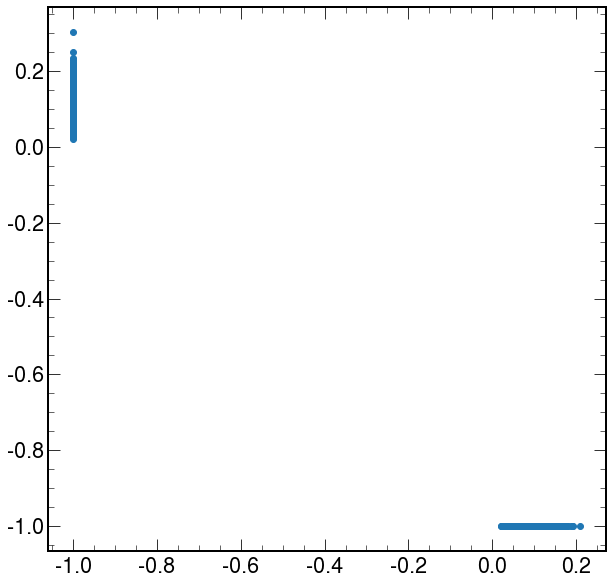

In [100]:
plt.hist(wdata[mask_np]['xip'])
plt.hist(wdata[mask_np]['xin'])
plt.show()

In [4]:
def defineAnalysisMasks(data):
    """
    defines common masks for selection of events in signal and control regions
    """
    good_wele = (data['probe_pt']>20) & ((abs(data['probe_eta'])<1.44) | (abs(data['probe_eta'])>1.55))
    masks={'emu'      : (data['channel']==143) & (data['isiso']>0)   & (data['boson_m']>50),
           'Znonres'  : (data['channel']==143) & (data['isiso']>0)   & (abs(data['boson_m']-91.)<15.),
           'ee'       : (data['channel']==121) & (data['isiso']>0)   & (data['boson_m']>50),
           'Zee'      : (data['channel']==121) & (data['isiso']>0)   & (abs(data['boson_m']-91.)<15.),
           'mumu'     : (data['channel']==169) & (data['isiso']>0)   & (data['boson_m']>50),
           'Zmumu'    : (data['channel']==169) & (data['isiso']>0)   & (abs(data['boson_m']-91.)<15.),
           'mu'       : (data['channel']==13)  & (data['isiso']>0),
           'munoniso' : (data['channel']==13)  & (data['isiso']==0),
           'Wmu'      : (data['channel']==13)  & (data['isiso']>0)   & (data['boson_m']>40.),
           'Wmunoniso': (data['channel']==13)  & (data['isiso']==0)  & (data['boson_m']>40.),
           'e'        : (data['channel']==11)  & (data['isiso']>0)   & good_wele,
           'enoniso'  : (data['channel']==11)  & (data['isiso']==0)  & good_wele,
           'We'       : (data['channel']==11)  & (data['isiso']>0)   & good_wele & (data['boson_m']>40.),
           'Wenoniso' : (data['channel']==11)  & (data['isiso']==0)  & good_wele & (data['boson_m']>40.),
           'pproton'  : (data[f'xip']>0.025)   & (data[f'xip']<0.15),
           'nproton'  : (data[f'xin']>0.040)   & (data[f'xin']<0.18)
        }
 
    masks['noproton']    = ~masks['pproton'] & ~masks['nproton']
    masks['pproton_exc'] =  masks['pproton'] & ~masks['nproton']
    masks['nproton_exc'] = ~masks['pproton'] &  masks['nproton']
    masks['twoprotons']  =  masks['pproton'] &  masks['nproton']

    #define final proton counting
    data['protoncat'] = 0
    data.loc[(masks['pproton_exc'] | masks['nproton_exc']),'protoncat']=1
    data.loc[masks['twoprotons'],'protoncat']=2

    #assign signed pseudo-rapidity distribution
    data['probe_sgneta'] = np.where(masks['pproton_exc'],data['probe_eta'],
                                    np.where(masks['nproton_exc'],-data['probe_eta'], -9999.))
    
    #variation with randomized sign
    probe_randsgneta = data['probe_eta'].values * np.random.choice([-1,1],data.shape[0])
    data['probe_randsgneta'] = np.where(masks['pproton_exc'] | masks['nproton_exc'], probe_randsgneta, -9999.)
        
    return masks

masks_dict=defineAnalysisMasks(data)

In [5]:
def showControlDistribution(data,
                            x='boson_m', xlabel=r'$M_T$ [GeV]', ylabel='Events',                            
                            bins=np.linspace(0,150,50), 
                            proc_list=[],
                            logy=False,
                            legendlabel=None,
                            outname=None):

    """
    standard plotting data/stacked background expectations
    data - the dataframe
    x - variable to plot
    {x,y}label - labels for x,y axis
    bins - bin definition
    bkg_list - list of (selection_mask, process_name, wgt_name, isDataFlag)
               the stack will be performed in the order given
               isDataFlag=True triggers the plotting as error bar instead of histogram
    logy - draw logarithmic y-scale
    legendlabel - header for the legend
    outname - if true the plot is saved with this name
    """

    xcen=0.5*(bins[1:]+bins[0:-1])    
   
    fig,ax=plt.subplots(figsize=(8,8))
    
    #create the stack of histograms and the data histogram
    hdata=None
    data_label=None
    hstack=[]
    stack_labels=[]
    for sel_mask, proc_name, wgt_name, isData in proc_list:
        xval  = data[sel_mask][x]
        wval  = None if wgt_name is None else data[sel_mask][wgt_name]
        histo = countInHistogram(xval,wval,bins)
        if isData:
            hdata=histo
            data_label=proc_name
        else:
            hstack.append(histo)
            stack_labels.append(proc_name)
        
    #stack the histograms
    sumw_stack = np.vstack([h[0] for h in hstack])
    sumw_stack = np.hstack([sumw_stack, sumw_stack[:,-1:]])  
    ax.stackplot(bins, sumw_stack, labels=stack_labels, step='post', edgecolor=(0, 0, 0, 0.5),)

    #show the data
    if not hdata is None:
        ebar_style={'marker':'o','elinewidth':1,'capsize':1,'ls':'none','color':'k'}
        ax.errorbar(x=xcen,y=hdata[0],yerr=hdata[1], label=data_label, **ebar_style)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if logy: ax.set_yscale('log')
    ax.grid()
    ax.legend(title=legendlabel)
    plt.tight_layout()
    hep.cms.label(loc=0,data=True,ax=ax,rlabel=r'$\sqrt{s}=13$ TeV (Run 2017H)',fontsize=18)
    if outname is None:
        plt.show()
    else:
        plt.savefig(f'{outname}.png')
        plt.close()
        
_channel_label={'e'    : 'e final state',
                'mu'   : r'$\mu$ final state',
                'Wmu'  : r'$W\rightarrow\mu\nu$',
                'We'   : r'$W\rightarrow e\nu$',
                'ee'   : 'ee final state',
                'mumu' : r'$\mu\mu$ final state',
                'Zmumu': r'$Z\rightarrow\mu\mu$',
                'Zee'  : r'$Z\rightarrow ee$',
                'munoniso' : 'non-iso $\mu$ final state',
                'enoniso' : 'non-iso e final state',
                'emu'  : r'e$\mu$ final state'}

## Background control

1. non-isolated backgrounds in the W analysis are extrapolated from the non-isolated sideband and normalized to MT<10 GeV
1. non-resonant backgrounds in the Z analysis are extrapolated from the emu sideband and scaled

The weights used to estimate these backgrounds will be added to the dataframe.

In [6]:
#
# non-isolated background estimation
#
mt_sideband = (data['boson_m']<10.)
for ch in ['e','mu']:
    
    data[f'{ch}nonisowgt']=0.

    #count the events in the sideband
    #and make the numbers agree between iso and non-iso
    iso     = masks_dict[f'{ch}'] 
    non_iso = masks_dict[f'{ch}noniso']
    data.loc[non_iso,f'{ch}nonisowgt'] = (iso & mt_sideband).sum() / (non_iso & mt_sideband).sum()
    
    #show the distribution to assert it has worked
    proc_list = [ (non_iso, 'Non-iso', f'{ch}nonisowgt', False ),
                  (iso,     'Data',    None,             True) ]
    
    showControlDistribution(data,
                            x='boson_m', xlabel=r'$M_T$ [GeV]', ylabel='Events',   
                            bins=np.linspace(0,150,50),                            
                            proc_list=proc_list,
                            logy=False,
                            legendlabel=_channel_label[ch],
                            outname=os.path.join(_plotsdir,f'{ch}_boson_m_bkg'))

In [7]:
#
# non-resonant background estimation
#
mll_sideband = ((data['boson_m']>55) & (data['boson_m']<70)) | ((data['boson_m']>110) & (data['boson_m']<125))
#met_sideband = (data['met_pt']>60)               
for ch in ['ee','mumu']:

    data[f'{ch}nonreswgt']=0.

    #count the events in the sideband
    #and make the numbers agree between iso and non-iso
    ll = masks_dict[ch]    
    em = masks_dict['emu']
    data.loc[em,f'{ch}nonreswgt'] = (ll & mll_sideband).sum() / (em & mll_sideband).sum()
    
    #show the distribution to assert it has worked
    proc_list = [ (em, 'Non-resonant', f'{ch}nonreswgt', False ),
                  (ll, 'Data',         None,             True) ]
    showControlDistribution(data,
                            x='boson_m', xlabel=r'$M(\ell,\ell)$ [GeV]', ylabel='Events',                            
                            bins=np.linspace(55,125,40), 
                            proc_list=proc_list,
                            logy=True,
                            legendlabel=_channel_label[ch],
                            outname=os.path.join(_plotsdir,f'{ch}_boson_m_bkg'))

In [8]:
#Z analysis plots
for x,xlabel,bins in [
     ('boson_m',      r'Dilepton invariant mass [GeV]',      np.linspace(91-15,91+15,20)),
     ('boson_pt',     r'Dilepton transverse momentum [GeV]', np.linspace(0,150,20)),
     ('probe_eta',    r'Dilepton pseudo-rapidity',           np.linspace(-6,6,21)),
     ('probe_sgneta', r'Signed dilepton pseudo-rapidity',    np.linspace(-6,6,21)),
     ('met_pt',       r'Missing transverse momentum [GeV]',  np.linspace(0,150,50)),
     ('npv',          r'Vertex multiplicity',                np.linspace(-0.5,9.5,11)),
     ('protoncat',    r'Proton multiplicity',                np.linspace(0,3,4)),
     ('xin',          r'$\xi$(-)',                           np.linspace(0,0.25,40)),
     ('xip',          r'$\xi$(+)',                           np.linspace(0,0.25,40)),
    ]:
    for ch in ['ee','mumu']:
        proc_list= [ (masks_dict['Znonres'], 'Non-resonant', f'{ch}nonreswgt', False ),
                     (masks_dict[f'Z{ch}'],  'Data',         None,             True) ]
        showControlDistribution(data,
                                x=x, xlabel=xlabel, ylabel='Events',                            
                                bins=bins,
                                proc_list=proc_list,
                                logy=False,
                                legendlabel=_channel_label[ch],
                                outname=os.path.join(_plotsdir,f'{ch}_{x}'))

In [9]:
#W analysis plots
for x,xlabel,bins in [  
     ('boson_m',      r'Transverse mass [GeV]',              np.linspace(40,150,40)),
     ('met_pt',       r'Missing transverse momentum [GeV]',  np.linspace(0,150,50)),
     ('probe_eta',    r'Lepton pseudo-rapidity',             np.linspace(-2.1,2.1,21)),
     ('probe_sgneta', r'Signed lepton pseudo-rapidity',      np.linspace(-2.1,2.1,21)),
     ('probe_pt',     r'Lepton transverse momentum [GeV]',   np.linspace(25,100,50)),
     ('npv',          r'Vertex multiplicity',                np.linspace(-0.5,9.5,11)),
     ('protoncat',    r'Proton multiplicity',                np.linspace(0,3,4)),
     ('xin',          r'$\xi$(-)',                           np.linspace(0,0.25,40)),
     ('xip',          r'$\xi$(+)',                           np.linspace(0,0.25,40)),
    ]:
    for ch in ['e','mu']:
        proc_list= [ (masks_dict[f'W{ch}noniso'], 'Non-iso', f'{ch}nonisowgt', False ),
                     (masks_dict[f'W{ch}'],       'Data',    None,             True) ]
        showControlDistribution(data,
                                x=x, xlabel=xlabel, ylabel='Events',                            
                                bins=bins,
                                proc_list=proc_list,
                                logy=False,
                                legendlabel=_channel_label[ch],
                                outname=os.path.join(_plotsdir,f'{ch}_{x}'))

In [10]:
def printEventYields(data,masks_dict,addMask=None):
    '''
    prints an event yields table, if no additional selection mask is passed a dummy one is created
    '''
    
    if addMask is None:
        addMask=np.ones(data.shape[0],dtype=bool)
    
    row='{:15s} {:15s} {:15s}'
    print(row.format('Channel','Background','Data'))

    for ch in ['e','mu']:
        nbkg = data[ masks_dict[f'W{ch}noniso'] & addMask ][ f'{ch}nonisowgt'].sum()
        nobs = (masks_dict[f'W{ch}'] & addMask).sum()
        print(row.format( ch, '%d'%nbkg, '%d'%nobs ))
        
    for ch in ['ee','mumu']:
        nbkg = data[ masks_dict['Znonres'] & addMask ][ f'{ch}nonreswgt'].sum()
        nobs = (masks_dict[f'Z{ch}'] & addMask).sum()
        print(row.format( ch, '%d'%nbkg, '%d'%nobs ))

    
print('Inclusive')
printEventYields(data,masks_dict)

print('+proton')
printEventYields(data,masks_dict, masks_dict['pproton_exc'])

print('-proton')
printEventYields(data,masks_dict, masks_dict['nproton_exc'])

Inclusive
Channel         Background      Data           
e               227402          1306130        
mu              159044          2018402        
ee              2063            73150          
mumu            3296            122962         
+proton
Channel         Background      Data           
e               12345           70374          
mu              8643            109378         
ee              170             3836           
mumu            272             6670           
-proton
Channel         Background      Data           
e               12222           71560          
mu              8815            111615         
ee              159             4044           
mumu            254             6686           


## Proton tag efficiency analysis

From the spectrum of the fraction of events with 1 proton as function of the vertex multiplicity we fit a pileup + single diffractive probabilistic model.

In [11]:
ptag_func="[0]*pow(1-[2],int(x+0.5))+[1]*TMath::Binomial(int(x+0.5), 1)*[2]*pow(1-[2],int(x+0.5-1))"

def fitProtonTagFraction(channel_mask,proton_mask,minvtx=0,maxvtx=11,npv='npv'):

    #count the total number of events as function of vertex multiplicity
    #before and after the proton requirement
    nbins  = maxvtx-minvtx
    htotal = ROOT.TH1F('total','total',nbins,minvtx-0.5,maxvtx-0.5)
    hpass  = ROOT.TH1F('pass', 'pass', nbins,minvtx-0.5,maxvtx-0.5)
    for xbin in range(1,htotal.GetNbinsX()+1):
        ivtx=minvtx+(xbin-1)
        vtx_mask=(data[npv]==ivtx) & channel_mask
        htotal.SetBinContent(xbin,vtx_mask.sum())
        hpass.SetBinContent(xbin, (vtx_mask & proton_mask).sum())    
        
    #convert to an efficiency plot
    eff = ROOT.TGraphAsymmErrors()
    eff.Divide(hpass,htotal, 'pois')
    
    #fit a binomial curve
    f=ROOT.TF1("f",ptag_func,1,maxvtx)
    f.SetLineColor(ROOT.kBlue)
    f.SetParLimits(0,0,1.0)
    f.SetParLimits(1,0,1.0)
    f.SetParLimits(2,0,1.0)

    eff.Fit(f,'NQMR+','',1,maxvtx)
    popt={
        'kSD':[f.GetParameter(0),f.GetParError(0)],
        'kPU':[f.GetParameter(1),f.GetParError(1)],
        'bPU':[f.GetParameter(2),f.GetParError(2)],
        'chi2':[f.GetChisquare(),f.GetNDF()]
    }
    
    f.FixParameter(0,0)
    eff.Fit(f,'NQMR+','',1,maxvtx)
    popt['kPU_bonly']=[f.GetParameter(1),f.GetParError(1)]
    popt['bPU_bonly']=[f.GetParameter(2),f.GetParError(2)]
    popt['chi2_bonly']=[f.GetChisquare(),f.GetNDF()]
          
    htotal.Delete()
    hpass.Delete()
    
    return eff,popt

def doProtonTagFractionAnalysis(side='p',npv='npv'):

    c=ROOT.TCanvas('c','c',500,500)
    c.SetTopMargin(0.05)
    c.SetLeftMargin(0.12)
    c.SetRightMargin(0.03)
    c.SetBottomMargin(0.1)
    mg=ROOT.TMultiGraph()

    fit_results={}
    for ch,marker in [('Wmu',20),('Zmumu',24),('We',None),('Zee',None),('emu',None),('munoniso',None)]:
        eff,popt = fitProtonTagFraction( masks_dict[ch], 
                                         masks_dict[f'{side}proton_exc'],
                                         npv=npv,
                                         minvtx=0)
        fit_results[ch]=popt
        
        
        if marker is None: continue
        eff.SetMarkerStyle(marker)
        eff.SetFillStyle(0)
        title=_channel_label[ch]
        for a,b in [('\\','#'),('$','')] : title=title.replace(a,b)
        eff.SetTitle(title)    
        mg.Add(eff,'p')
    mg.Draw('ap')
    
    mg.GetYaxis().SetTitle('N_{proton tag} / N_{all}')
    mg.GetXaxis().SetTitle('Vertex multiplicity')
    mg.GetYaxis().SetRangeUser(0,0.15)
        
    #add the model on top
    f=ROOT.TF1("sdpu",ptag_func,1,10.5)
    f.SetTitle('SD+PU')
    f.SetLineColor(ROOT.kBlue)
    f.SetLineWidth(2)
    f.SetParameter(0,fit_results['Wmu']['kSD'][0])
    f.SetParameter(1,fit_results['Wmu']['kPU'][0])
    f.SetParameter(2,fit_results['Wmu']['bPU'][0])
    f.Draw('same')
    
    fb=f.Clone('pu')
    fb.SetTitle('PU')
    fb.SetLineColor(ROOT.kGreen+3)
    fb.SetLineStyle(2)
    fb.SetParameter(0,0.)
    fb.SetParameter(1,fit_results['Wmu']['kPU_bonly'][0])
    fb.SetParameter(2,fit_results['Wmu']['bPU_bonly'][0])
    fb.Draw('same')

    leg=c.BuildLegend(0.15,0.93,0.7,0.67)
    leg.SetTextFont(42)
    leg.SetTextSize(0.04)
    leg.SetFillStyle(0)
    leg.SetBorderSize(0)

    c.SetGridx()
    c.SetGridy()
    c.SaveAs(os.path.join(f'{_plotsdir}/{side}_protontageff_{npv}.png'))
    
    return fit_results

#loop over different sides and vertex counting possibilities
#gather the results of the fits to SD+PU or only PU
ptag_fitresults=[]
for npv,side in itertools.product(['npv','npvgood'],['n','p']):
    fit_res=doProtonTagFractionAnalysis(side,npv=npv)
    for sample in fit_res:
        ptag_fitresults.append([npv,side,sample])
        for k in fit_res[sample]:
            ptag_fitresults[-1] += fit_res[sample][k]
            
#convert the results to a dataframe
ptag_fitresults=pd.DataFrame(ptag_fitresults,
                             columns=['npv','side','sample','kSD','kSDunc','kPU','kPUunc','bPU','bPUunc','chi2','ndf','kPU_bonly','kPUunc_bonly','bPU_bonly','bPUunc_bonly','chi2_bonly','ndf_bonly'])        
ptag_fitresults['pval']=chi2.sf(ptag_fitresults['chi2'],ptag_fitresults['ndf'])
ptag_fitresults['pval_bonly']=chi2.sf(ptag_fitresults['chi2_bonly'],ptag_fitresults['ndf_bonly'])
ptag_fitresults.head()

npv side sample       kSD    kSDunc       kPU    kPUunc       bPU  \
0  npv    n    Wmu  0.008607  0.000663  0.296167  0.011263  0.055984   
1  npv    n  Zmumu  0.007627  0.002805  0.275709  0.039577  0.062036   
2  npv    n     We  0.010368  0.000808  0.333446  0.021958  0.046237   
3  npv    n    Zee  0.010289  0.003389  0.367032  0.120309  0.042353   
4  npv    n    emu  0.013122  0.012984  1.000000  0.806225  0.011149   

     bPUunc      chi2  ndf  kPU_bonly  kPUunc_bonly  bPU_bonly  bPUunc_bonly  \
0  0.003316  8.205245    7   0.239964      0.003424   0.088079      0.001731   
1  0.014403  9.327183    7   0.231231      0.013300   0.091901      0.007312   
2  0.004374  2.422495    7   0.241464      0.004481   0.086865      0.002201   
3  0.019227  4.847409    7   0.252111      0.021304   0.083931      0.009526   
4  0.004236  1.647353    7   0.278026      0.260571   0.063389      0.078267   

   chi2_bonly  ndf_bonly      pval    pval_bonly  
0  164.903959          8  0.314844  1.506286e-31  
1   16.407466          8  0.230011  3.690576e-02  
2  152.600344          8  0.932819  5.621684e-29  
3   13.102734          8  0.678578  1.083634e-01  
4    2.277697          8  0.976766  9.712929e-01

Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 1 points have been skipped
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 1 points have been skipped
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 1 points have been skipped
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 1 points have been skipped
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 1 points have been skipped
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 1 points have been skipped
Info in <TCanvas::Print>: png file /eos/user/p/psilva/www/sdanalysis/2021Oct27/n_protontageff_npv.png has been created
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 1 points have been skipped
Warnin

In [12]:
#summarize proton tag analysis

#loop over the different vertex counting algorithms
for key,group in ptag_fitresults.groupby('npv'):
    
    #if key!='npvgood': continue
    
    #compare the fitted values or the p-value of the fits for different samples
    for p,ptitle in [('pval','p-val'),('kSD',r'$\kappa_{SD}$'),('bPU',r'$\beta_{PU}$')]:

        fig,ax=plt.subplots(figsize=(8,8))
        
        #each entry in the y axis is a sample
        y=np.arange(group.shape[0])
        ylabels=[_channel_label[x] for x in group['sample'].values]
        side=group['side'].values
        for i,s in enumerate(side):
            ylabels[i] += '(+)' if side[i]=='p' else '(-)'

        #put the values and uncertainties (if available) in the x-axis
        x=group[p].values
        xerr=group[p+'unc'].values if p!='pval' else np.zeros_like(x)
        ebar_style={'marker':'o','elinewidth':1,'capsize':1,'ls':'none','markersize':12}
        ax.errorbar(x=x, xerr=xerr, y=y+0.1, color='k', **ebar_style, label='SD+PU')
        
        #add the results of the PU-only fit, if available
        if p+'_bonly' in group.columns:
            x=group[p+'_bonly'].values
            xerr=group[p+'unc_bonly'].values if p!='pval' else np.zeros_like(x)
            ax.errorbar(x=x, xerr=xerr, y=y-0.1, color='k', **ebar_style, label='SD',fillstyle='none')
            ax.legend()
         
        #fiddle final format
        ax.set_yticks(y)
        ax.set_ylim(min(y)-1,max(y)+2)
        maxx=1
        if p=='kSD': maxx=0.03
        if p=='bPU': maxx=0.15
        ax.set_xlim(0,maxx)
        ax.set_yticklabels(ylabels,rotation='horizontal')
        ax.set_ylabel('Category')
        ax.set_xlabel(ptitle)        
        ax.grid()
        plt.tight_layout()
        hep.cms.label(loc=1,data=True,ax=ax,rlabel=r'$\sqrt{s}=13$ TeV (Run 2017H)',fontsize=18)

        #save to file
        pname=outname=os.path.join(_plotsdir,f'{key}_{p}_summary.png')
        plt.savefig(pname)
        plt.close()

## Counting analysis

We count the selected events in different categories and write datacards to combine

In [20]:
def buildCountingHistograms(channel='mu',minvtx=0,maxvtx=3,npvcoll='npv'):
    
    nsd,other,otherwgt=f'W{channel}',f'W{channel}noniso',f'{channel}nonisowgt'
    if channel=='mumu' or channel=='ee': 
        nsd,other,otherwgt=f'Z{channel}','Znonres',f'{channel}nonreswgt'
    
    #define two bins for positive and negative eta
    var_dict={'p':'probe_sgneta',
              'n':'probe_sgneta',
               None:'probe_eta'}
    bins_dict={'p':np.linspace(-2.1,2.1,3),
               'n':np.linspace(-2.1,2.1,3),
                None:np.linspace(-2.1,2.1,2) }
    side_label_dict={'p':'+', 'n':'-', None:'0p'}
        
    #iterate over categories
    bin_labels=[]
    bin_keys=[]
    full_histos={}
    def _addToFullHistos(key,cts,uncs):
        
        """helper method to add more counts to the full histograms per process"""

        if not key in full_histos:
            full_histos[key]=[cts.copy(),uncs.copy()]
        else:
            full_histos[key][0]=np.hstack( [full_histos[key][0],cts] )
            full_histos[key][1]=np.hstack( [full_histos[key][1],uncs] )

    #for side,npv in itertools.product([None,'p','n'],range(minvtx,maxvtx+1)):
    if not minvtx is None and not maxvtx is None:
        side_npv_list=itertools.product(['p','n'],range(minvtx,maxvtx+1))
    else:
        side_npv_list=[('p',None),('n',None)]    
    for side,npv in side_npv_list:
        
        var=var_dict[side]
        side_label=side_label_dict[side]
        bins=bins_dict[side]
        if side is None:
            bin_labels += [f'({side_label},{npv})']
            bin_keys   += [('nop','inc',npv)]
        elif not npv is None:
            bin_labels += [ fr'($\eta<0$,{side_label}), {npv}',fr'($\eta>0$,{side_label}), {npv}' ]
            bin_keys   += [ (side,'neg',npv), (side,'pos',npv)]
        else:
            bin_labels += [ fr'($\eta<0$,{side_label})',fr'($\eta>0$,{side_label})' ]
            bin_keys   += [ (side,'neg',npv), (side,'pos',npv)]
            
        
        mask_cat=np.ones_like(data[npvcoll].values,dtype=bool)
        if not npv is None:
            mask_cat=(data[npvcoll]==npv) 
        if not side is None:
            mask_cat &= masks_dict[f'{side}proton_exc']
        else:
            mask_cat &= ~masks_dict['pproton'] & ~masks_dict['nproton']

        #residual processes
        mask_other          = masks_dict[other] & mask_cat
        othercts, otheruncs = countInHistogram(data[mask_other][var], data[mask_other][otherwgt], bins)
        _addToFullHistos('other',othercts,otheruncs)
        
        #observation and NSD share the same mask
        mask_nsd = masks_dict[nsd] & mask_cat
        
        #observed counts
        obscts, obsuncs = countInHistogram(data[mask_nsd][var], None, bins)
        total_obs       = obscts.sum()
        _addToFullHistos('obs',obscts,obsuncs)

        #NSD: taken from the randomized variable
        #as the initial normalization will come out the same as observed scale by  (obs-others)/nsd
        nsdcts, nsduncs = countInHistogram(data[mask_nsd][var.replace('sgn','randsgn')], None, bins)
        kfact           = (total_obs-othercts.sum())/total_obs if total_obs>0 else 0.
        nsdcts          = nsdcts*kfact
        nsduncs         = nsduncs*kfact
        _addToFullHistos('nsd',nsdcts,nsduncs)
            
    return bin_keys,bin_labels,full_histos

#buildCountingHistograms(maxvtx=3)
#buildCountingHistograms(minvtx=None,maxvtx=None)

In [21]:
def showCountingHistogram(channel='mu',minvtx=0,maxvtx=3,npvcoll='npv'):
    
    """uses the counting histograms and makes a final plot"""

    #get the histograms
    _,bin_labels,full_histos = buildCountingHistograms(channel=channel,minvtx=minvtx,maxvtx=maxvtx,npvcoll=npvcoll)
    
    #show the stacked comparisons to data
    fig,ax=plt.subplots(figsize=(8,8))
    
    #stack the histograms
    x=np.arange(len(bin_labels)+1)
    sumw_stack = np.vstack([full_histos[p][0] for p in ['other','nsd']])
    sumw_stack = np.hstack([sumw_stack, sumw_stack[:,-1:]])
    ax.stackplot(x, sumw_stack, labels=['Other','NSD'], step='post', edgecolor=(0, 0, 0, 0.5),)

    #data is represented as errorbar
    xcen=0.5*(x[1:]+x[0:-1])    
    ebar_style={'marker':'o','elinewidth':1,'capsize':1,'ls':'none','markersize':12}
    ax.errorbar(x=xcen, y=full_histos['obs'][0], yerr=full_histos['obs'][1], color='k', **ebar_style, label='Data')
   
    #fiddle final format
    ax.set_xticks(xcen)
    ax.set_xlim(min(x),max(x))
    ax.set_xticklabels(bin_labels,rotation='vertical')
    ax.set_xlabel('Category')
    ax.set_ylabel('Events')
    ax.grid()

    ax.legend()

    plt.tight_layout()
    pfix='_inc' if minvtx is None and maxvtx is None else ''
    hep.cms.label(loc=0,data=True,ax=ax,rlabel=r'$\sqrt{s}=13$ TeV (Run 2017H)',fontsize=18)
    plt.savefig(os.path.join(_plotsdir,f'prefitcounts_{channel}_{npvcoll}{pfix}.png'))
    
    ax.set_yscale('log')
    plt.savefig(os.path.join(_plotsdir,f'prefitcounts_{channel}_{npvcoll}{pfix}_log.png'))
    plt.close()

for ch,npv in itertools.product(['mu','e','mumu','ee'],['npv','npvgood']):
    showCountingHistogram(channel=ch,npvcoll=npv)
    showCountingHistogram(channel=ch,npvcoll=npv,minvtx=None,maxvtx=None)

In [23]:
def SDProbability(proton,vtx,fvtx,pu_beta,sig_eff,sig_acc):
    """
    defines the SD probabilistic model as function of the number of protons (nop/p/n), vertex multiplicity
    takes:
    - the fraction of events with vtx vertices (fvtx)
    - the pileup proton probability dict (pu_beta={side:val})
    - the signal efficiency (sig_eff={side:val})
    - the signal acceptance (sig_acc={side:val})
    assumes 1 vertex from signal, (vtx-1) vertices from pileup
    returns the probability to observe a proton on the negative and on the positive side
    the probability will be not normalized in a restricted vertex multiplicity region, thus it needs to be normalized a posteriori
    """
    
    #common scaling factor
    nop_kfact = fvtx[vtx]*((1-pu_beta['bPU']['n'])**vtx)*((1-pu_beta['bPU']['p'])**vtx)
    
    #no protons requires full innefficiency of signal and pileup
    if proton=='nop':
        sd_kfact = (sig_acc['n']*(1-sig_eff['n'])+sig_acc['p']*(1-sig_eff['p']))*nop_kfact
        
    #1 proton from signal or from signal inefficiency and pileup contribution
    #the later requires taking one vertex out of PU and multipliying by the corresponding probability
    else:            
        sd_kfact = sig_acc[proton]*sig_eff[proton]*nop_kfact        
        if vtx>1:
            pu_prob = (vtx-1)*(pu_beta['bPU'][proton]/(1-pu_beta['bPU'][proton]))*nop_kfact
            sd_kfact += (sig_acc['n']*(1-sig_eff['n'])+sig_acc['p']*(1-sig_eff['p']))*pu_prob

    return sd_kfact


def NSDProbability(proton,vtx,fvtx,pu_beta):
    """
    defines the NSD probabilistic model as function of the number of protons (nop/p/n), vertex multiplicity
    takes:
    - the fraction of events with vtx vertices (fvtx)
    - the pileup proton probability dict (pu_beta={side:val})
    - the nsd acceptance (sig_acc={side:val})
    assumes all vertices in equal footing, one giving a pileup proton
    returns the probability to observe a proton on the negative and on the positive side
    the probability will be not normalized in a restricted vertex multiplicity region, thus it needs to be normalized a posteriori
    """
    
    #common scaling factor (no pileup protons)
    nop_kfact = fvtx[vtx]*((1-pu_beta['bPU']['n'])**vtx)*((1-pu_beta['bPU']['p'])**vtx)
    if proton =='nop':
        nsd_kfact = nop_kfact

    #take 1 vertex to yield a proton
    else:
        nsd_kfact = vtx*(pu_beta['bPU'][proton]/(1-pu_beta['bPU'][proton]))*nop_kfact
               
    return nsd_kfact


def buildProbabiltyModel(channel='mu',minvtx=1,maxvtx=3):
    
    sample=f'W{channel}'
    if channel=='mumu' or channel=='ee': sample=f'Z{channel}'
    
    #get the counting histograms
    bin_keys,_,full_histos = buildCountingHistograms(channel=channel,minvtx=minvtx,maxvtx=maxvtx,npvcoll='npv')
    
    if minvtx is None and maxvtx is None:
        return bin_keys,full_histos
    
    #
    # for exclusive vertex counting use a probabilisitic model
    # fixed parameters of the model
    #
    
    # proton/PV probability : get the values fitted for beta in the proton tag analysis
    # in the form dict {parname:{side:val, side:val}, parname:{...} }
    ptag_sel=(ptag_fitresults['sample']==sample) & (ptag_fitresults['npv']=='npv')
    pu_beta = ptag_fitresults[ptag_sel][['side','bPU','bPUunc']].set_index('side').to_dict()

    # signal efficiency : while there is no estimate assume full efficiency in both sides
    # likewise assume equal acceptance
    sig_eff={'n':1.0,'p':1.0}
    sig_acc={'n':0.5,'p':0.5}
    
    # vertex fraction
    vtx_obs = dict([(key[2], full_histos['obs'][0][i]) for i,key in enumerate(bin_keys) if key[0]=='p'])
    total_vtx_obs = sum( vtx_obs.values() )
    fvtx = dict([(i,vtx_obs[i]/total_vtx_obs) for i in vtx_obs])
    
    #build the SD and NSD probabilitistic model
    #this should evolve to a loop to evaluate different systematics by varying
    #pu_beta, signal_efficiency, sig_accetance, nsd_acceptance separately for positive/negative => 8 variations
    sd_proba=[]
    nsd_proba=[]
    for i,key in enumerate(bin_keys):
        
        proton,eta,vtx=key        
        sd_kfact = SDProbability(proton,vtx,fvtx,pu_beta,sig_eff,sig_acc)
        
        r=(1-0.1)/(1+0.1)
        rfact = 1/(1+r) if eta=='neg' else r/(1+r)
        sd_proba.append( sd_kfact )
        
        nsd_kfact = NSDProbability(proton,vtx,fvtx,pu_beta)
        nsd_proba.append( nsd_kfact )
        
    #set as a normalized distribution to be used as PDF
    sd_proba=np.array(sd_proba)
    sd_proba=sd_proba/sd_proba.sum()
    full_histos['sd_proba']=[sd_proba]

    nsd_proba=np.array(nsd_proba)
    nsd_proba=nsd_proba/nsd_proba.sum()
    full_histos['nsd_proba']=[nsd_proba]
  
    #return final counts and uncertainties to be used in the datacard
    return bin_keys,full_histos

_=buildProbabiltyModel()

In [27]:
def writeYieldsDatacard(channel='mu',minvtx=1,maxvtx=3):
    
    bin_keys,full_histos=buildProbabiltyModel(channel,minvtx=minvtx,maxvtx=maxvtx)

    nsd_cts=full_histos['nsd'][0].sum()    
    
    pfix='_inc' if minvtx is None and maxvtx is None else ''
    
    for ibin,(proton,eta,ivtx) in enumerate(bin_keys):
         
        bin_name=f'{channel}_{proton}_{eta}_{ivtx}{pfix}'
        with open(os.path.join(_plotsdir,f'{bin_name}.dat'),'w') as dc:
            
            #header
            dc.write(f'imax *\n')
            dc.write('jmax *\n')
            dc.write('kmax *\n')
            dc.write('-'*50+'\n')
            
            #observed values
            dc.write('{:15s} {:15s}\n'.format('bin',bin_name))
            dc.write('{:15s} {:15s}\n'.format('observation','%d'%full_histos['obs'][0][ibin]))
            dc.write('-'*50+'\n')

            #declare as counting experiment for combine
            dc.write('shapes * * FAKE\n')
            dc.write('-'*50+'\n')
            
            #signal and background expectations
            dc.write('{0:15s} {1:15s} {1:15s} {1:15s}\n'.format('bin',bin_name))
            dc.write('{:15s} {:15s} {:15s} {:15s}\n'.format('process','SD','NSD','other'))
            dc.write('{:15s} {:15s} {:15s} {:15s}\n'.format('process','0','1','2'))
                        
            if 'sd_proba' in full_histos:
                exp_yields='{0:15s} {1:15s} {2:15s}'.format('%3.4f'%(full_histos['sd_proba'][0][ibin]),
                                                            '%3.4f'%(full_histos['nsd_proba'][0][ibin]*nsd_cts),
                                                            '%3.4f'%full_histos['other'][0][ibin])
            else:
                exp_yields='{0:15s} {1:15s} {2:15s}'.format('%3.4f'%(0.25),
                                                            '%3.4f'%(full_histos['nsd'][0][ibin]),
                                                            '%3.4f'%full_histos['other'][0][ibin])
                
            dc.write('{:15s} {}\n'.format('rate',exp_yields))
            dc.write('-'*50+'\n')
            
            #systematics
            #NSD 
            if eta=='neg':
                nsd_rand_neg = full_histos['nsd'][0][ibin]
                nsd_rand_pos = full_histos['nsd'][0][ibin+1]
                res_nsd_asymm = 1+abs(1-nsd_rand_neg/nsd_rand_pos)
                dc.write('{:25s}\tlnN\t{:10s} {:10s} {:10s}\n'.format(f'res_nsd_asymm_{bin_name}',
                                                                      '-',
                                                                      '%3.4f'%res_nsd_asymm,
                                                                      '-'))
                
            
            #others (stat unc uncorr. + overall normalization corr.)
            other_statunc = 1.+full_histos['other'][1][ibin]/full_histos['other'][0][ibin]
            dc.write('{:25s}\tlnN\t{:10s} {:10s} {:10s}\n'.format(f'otherstat_{bin_name}',
                                                                  '-',
                                                                  '-',
                                                                  '%3.4f'%other_statunc))
            dc.write('{:25s}\tlnN\t{:10s} {:10s} {:10s}\n'.format(f'othernorm',
                                                                  '-',
                                                                  '-',
                                                                  '1.3'))
            dc.write('nsdScale rateParam * NSD 1.0\n')
            
for ch in ['mu','e']:
    #writeYieldsDatacard(ch)
    writeYieldsDatacard(ch,minvtx=None,maxvtx=None)    

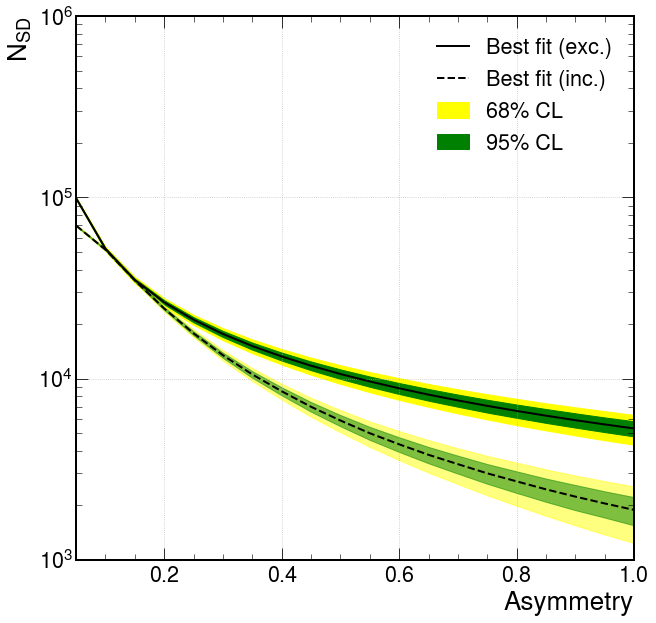

In [41]:
#likelihood scan
data_inc=pd.read_hdf('/eos/user/p/psilva/www/sdanalysis/2021Oct21/nll_scan_inc_e.h5',key='nll')
data_exc=pd.read_hdf('/eos/user/p/psilva/www/sdanalysis/2021Oct21/nll_scan_e.h5',key='nll')

data=data_exc.merge(data_inc,on='A',suffixes=('','_inc'))

idx=data['A'].values.argsort()

plt.fill_between(data['A'][idx],data['muSD_95dn'][idx],data['muSD_95up'][idx],color='yellow',label='68% CL')
plt.fill_between(data['A'][idx],data['muSD_dn'][idx],data['muSD_up'][idx],color='green',label='95% CL')
plt.plot(data['A'][idx],data['muSD'][idx],linewidth=2,color='k',label='Best fit (exc.)')

plt.fill_between(data['A'][idx],data['muSD_95dn_inc'][idx],data['muSD_95up_inc'][idx],color='yellow',alpha=0.5)
plt.fill_between(data['A'][idx],data['muSD_dn_inc'][idx],data['muSD_up_inc'][idx],color='green',alpha=0.5)
plt.plot(data['A'][idx],data['muSD_inc'][idx],linewidth=2,color='k',ls='--',label='Best fit (inc.)',)


plt.legend()
plt.xlabel('Asymmetry')
plt.ylabel(r'$N_{SD}$')
plt.yscale('log')
plt.xlim(0.05,1)
plt.ylim(1e3,1e6)
plt.grid()
plt.show()